# Read and visualize dicom files

### Imports

In [68]:
import sys
import os
from glob import glob
import napari
import pydicom
import zarr
import numpy as np
import pandas as pd
import random
import skimage
from skimage.filters import threshold_otsu
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns

### Paths

In [4]:
data_dir = '/Users/nikhil/Downloads/'
img_dir = data_dir + 'Series-2/'

### Read dicoms 

In [5]:
# load the DICOM files
files = []
print('glob: {}'.format('{}'.format(img_dir)))
for fname in glob('{}/*.dcm'.format(img_dir)):
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

glob: /Users/nikhil/Downloads/Series-2/
file count: 84
skipped, no SliceLocation: 0


### view 2d slices

Text(0.5, 1.0, 'sample binarization')

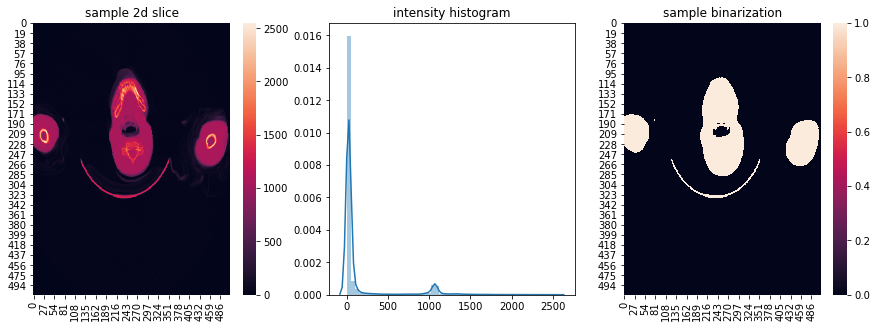

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
ax = axes[0]
g = sns.heatmap(img2d,ax=ax)
ax.set_title('sample 2d slice')

ax = axes[1]
g = sns.distplot(img2d.ravel(),ax=ax)
ax.set_title('intensity histogram')

# sample binary slice
thresh = threshold_otsu(img2d)
binary = img2d > thresh

ax = axes[2]
g = sns.heatmap(binary,ax=ax)
ax.set_title('sample binarization')

### threshold, binarize, and find peaks

In [7]:
def get_lung_location(img,slice_axes=(0,1)):
    ''' Finds start and end slice index for a 3d image based on foreground pixel sum in each slice
    '''
    thresh = threshold_otsu(img)
    img_binary = img > thresh
    slice_sum = np.sum(img_binary,axis=slice_axes)
    peaks, _ = find_peaks(slice_sum, height=np.mean(slice_sum))
    start_slice_idx = np.min(peaks)
    end_slice_idx = np.max(peaks)
    endpoints = [start_slice_idx,end_slice_idx]
    
    return slice_sum, endpoints
    
    

In [8]:
slice_sum, lung_endpoints = get_lung_location(img3d)


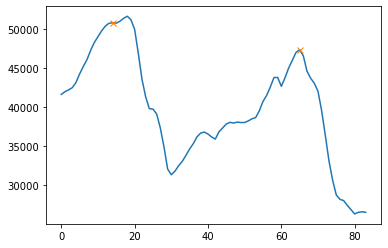

In [9]:
plt.plot(slice_sum)
plt.plot(lung_endpoints, slice_sum[lung_endpoints], "x")

### Pick slice samples
- Sampling is designed to provide slices from 'similar' lung locations for case and control groups
- Process: 
    - We first divide lung into N partitions (e.g. top,middle,bottom)
    - We then sample same number of slices from each partition for a given CT image and a given group 

In [92]:
def get_slice_locations(CT_endpoints,n_CT_partitions,n_samples_per_scan):
    
    n_CT_scans = len(CT_endpoints)
    
    assert n_samples_per_scan > n_CT_partitions #don't want to undersample
    
    n_samples_per_CT_partitions = n_samples_per_scan//n_CT_partitions
        
    print('Number of CT scans {}, CT_partitions: {}, samples per scan: {}, n_samples_per_CT_partitions: {}'.format(n_CT_scans,
                                                                                      n_CT_partitions,
                                                                                      n_samples_per_scan,
                                                                                      n_samples_per_CT_partitions))
    

    
    sample_df = pd.DataFrame()
    for CT_id, CT_endpoints in CT_endpoints.items():
        
        n_available_slices = CT_endpoints[1] - CT_endpoints[0]
        assert n_available_slices > n_samples_per_scan #don't want to repeat samples
        
        sample_ids_dict = sample_paritions(CT_endpoints, n_CT_partitions, n_samples_per_CT_partitions)

        df = pd.DataFrame()
        df['CT_id'] = np.repeat(CT_id,n_CT_partitions)
        df['partition_id'] = list(sample_ids_dict.keys())
        df['slice_ids'] = list(sample_ids_dict.values())
        
        sample_df = sample_df.append(df)
        
    return sample_df

def sample_paritions(endpoints, n_partitions, n_samples_per_partition,random_seed=153):
    partitions = np.array_split(np.arange(endpoints[0],endpoints[1]),n_partitions)
    sample_ids_dict = {}
    random.seed(random_seed)
    for p, part in enumerate(partitions):
        sample_ids = random.sample(list(part),n_samples_per_partition,)
        sample_ids_dict[p] = sample_ids
        
    return sample_ids_dict
        

In [93]:
# example: 
CT_endpoints = {1:[10,100],2:[25,75]}
n_CT_partitions = 4
n_samples_per_scan = 10

get_slice_locations(CT_endpoints,n_CT_partitions,n_samples_per_scan)

Number of CT scans 2, CT_partitions: 4, samples per scan: 10, n_samples_per_CT_partitions: 2


,CT_id,partition_id,slice_ids
0,1,0,"[25, 12]"
1,1,1,"[34, 41]"
2,1,2,"[69, 74]"
3,1,3,"[96, 97]"
0,2,0,"[32, 26]"
1,2,1,"[38, 42]"
2,2,2,"[62, 57]"
3,2,3,"[72, 74]"


### Napari 3d views

In [17]:
with napari.gui_qt():
    viewer = napari.view_image(img3d)